In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, roc_auc_score

# 1. Path Management: Reach out of the sub-folder for the data
data_path = '../diabetic_data.csv'

if os.path.exists(data_path):
    df = pd.read_csv(data_path)
    print("Dataset loaded successfully.")
else:
    # Fallback for different folder depths
    df = pd.read_csv('diabetic_data.csv')

# 2.  Cleaning Logic
df.replace('?', np.nan, inplace=True)
df.drop(columns=['weight', 'payer_code', 'medical_specialty', 'encounter_id', 'patient_nbr'], inplace=True)
df.dropna(subset=['diag_1', 'diag_2', 'diag_3', 'race'], inplace=True)
df['readmitted'] = df['readmitted'].replace({'>30': 1, '<30': 1, 'NO': 0})

# 3. Encoding (Label Encoding is standard for Trees)
le = LabelEncoder()
for col in df.select_dtypes(include=['object']).columns:
    df[col] = le.fit_transform(df[col].astype(str))

# 4. Train-Test Split (80/20)
X = df.drop('readmitted', axis=1)
y = df['readmitted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Ready for Modeling. Total Features: {X_train.shape[1]}")

Dataset loaded successfully.


C:\Users\dkshp\AppData\Local\Temp\ipykernel_11320\453748303.py:29: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  for col in df.select_dtypes(include=['object']).columns:


Ready for Modeling. Total Features: 44


======= DECISION TREE PERFORMANCE =======
Accuracy Score: 0.6243
ROC-AUC Score: 0.6615

Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.73      0.67     10432
           1       0.62      0.50      0.56      9179

    accuracy                           0.62     19611
   macro avg       0.62      0.62      0.62     19611
weighted avg       0.62      0.62      0.62     19611



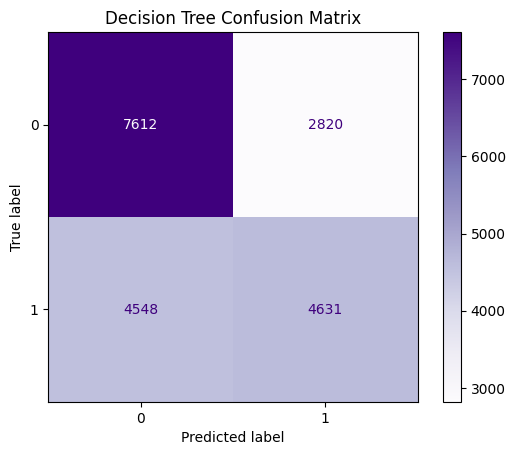

In [ ]:
# 1. Model Initialization
# 'entropy' measures the quality of a split. 
# max_depth=5 ensures the tree doesn't get too 'messy' or overfit.
dt_model = DecisionTreeClassifier(
    criterion='entropy', 
    max_depth=5, 
    min_samples_leaf=50, 
    random_state=42
)

# 2. Training
dt_model.fit(X_train, y_train)

# 3. Predictions
y_pred = dt_model.predict(X_test)
y_prob = dt_model.predict_proba(X_test)[:, 1]

# 4. Results Output
print("======= DECISION TREE PERFORMANCE =======")
print(f"Accuracy Score: {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# 5. Visualizing the Confusion Matrix
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Purples')
plt.title('Decision Tree Confusion Matrix')
plt.show()

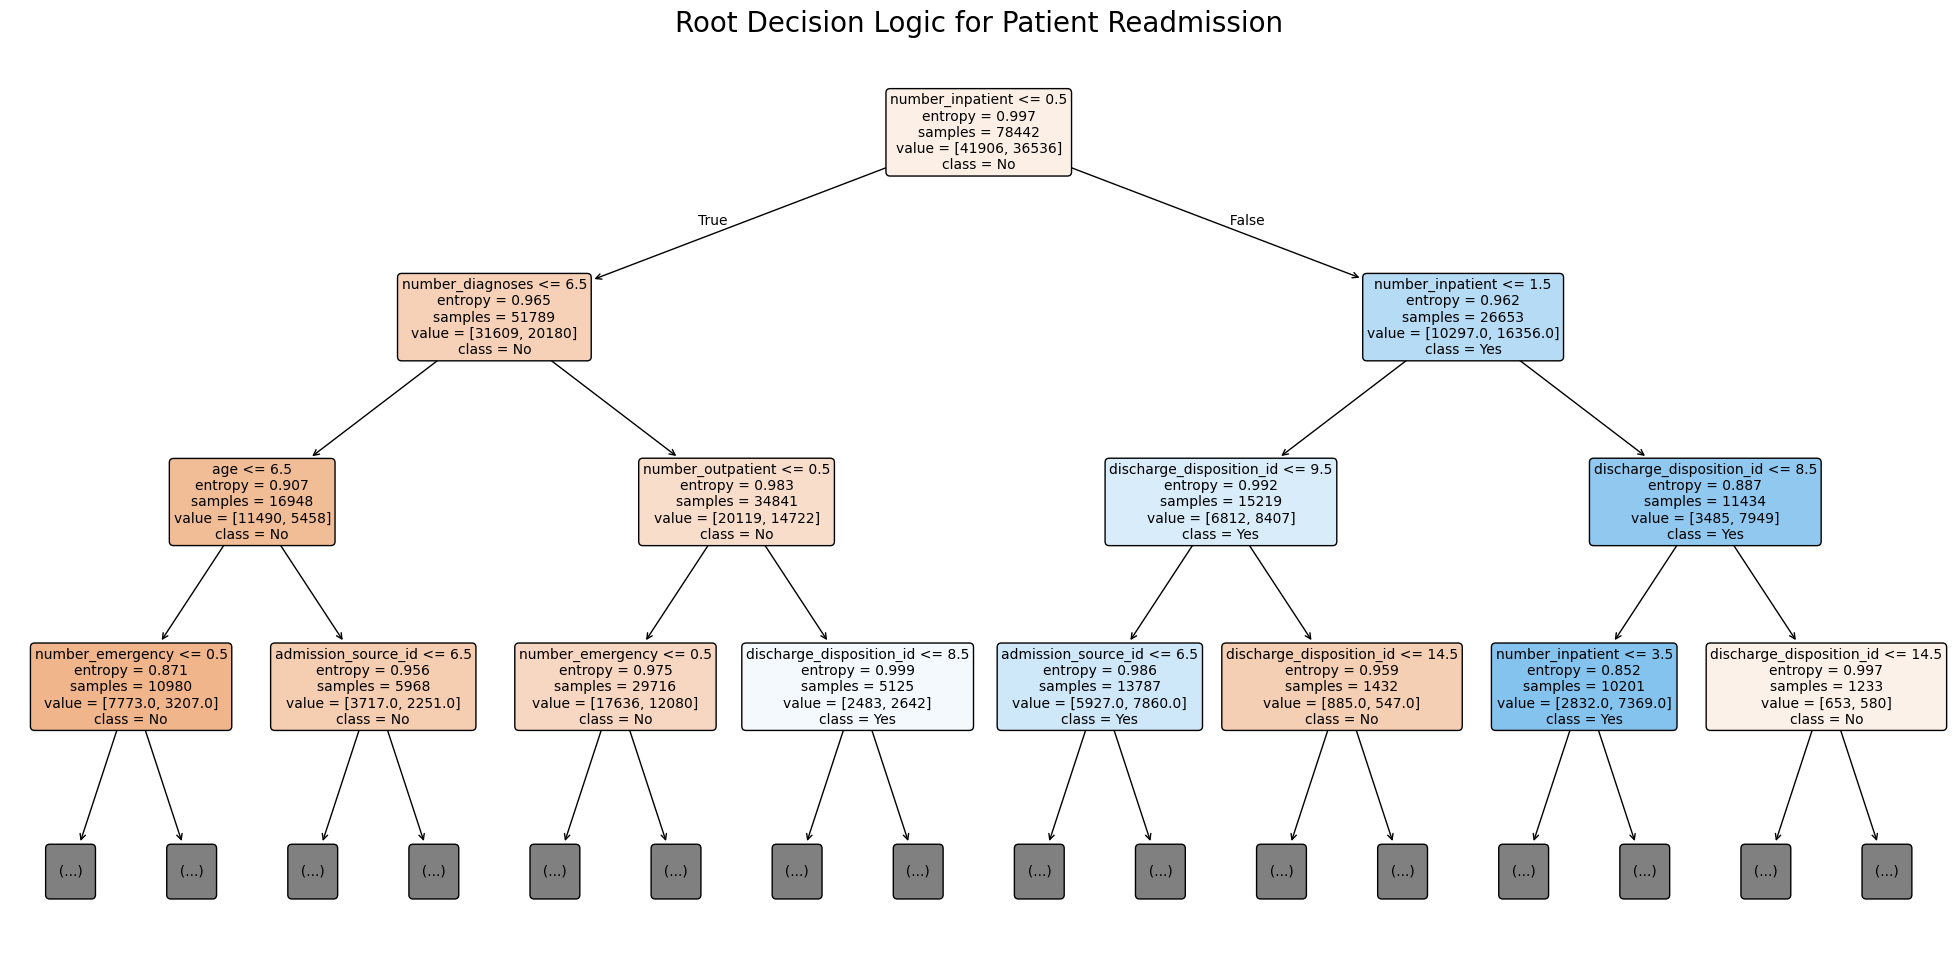

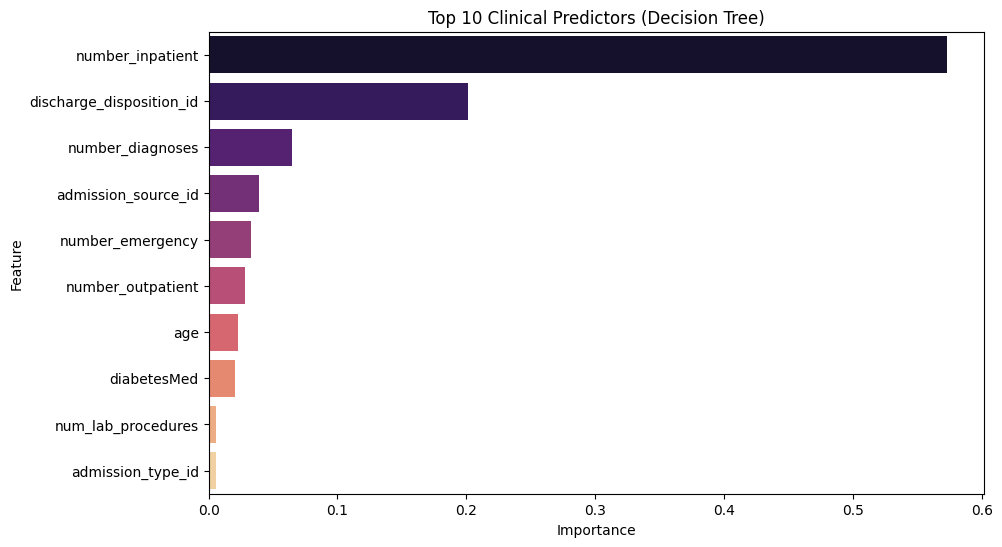

The most important clinical predictor is: number_inpatient


In [ ]:
# 1. Plotting the Tree Logic
# We limit the plot to depth 3 so it's readable, even though the model is depth 5.
plt.figure(figsize=(25, 12))
plot_tree(
    dt_model, 
    feature_names=X.columns, 
    class_names=['No', 'Yes'], 
    filled=True, 
    rounded=True, 
    fontsize=10,
    max_depth=3 
)
plt.title("Root Decision Logic for Patient Readmission", fontsize=20)
plt.show()

# 2. Extracting Feature Importance
# This shows which clinical variables had the most 'splitting power'
importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': dt_model.feature_importances_
}).sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances, hue='Feature', palette='magma', legend=False)
plt.title("Top 10 Clinical Predictors (Decision Tree)")
plt.show()

# 3. Print the top feature for your report
print(f"The most important clinical predictor is: {importances.iloc[0]['Feature']}")

In [ ]:
import os
from sklearn.metrics import precision_recall_fscore_support

# 1. Extract the specific metrics for Class 1 (Readmitted)
# precision_recall_fscore_support returns arrays for [Class 0, Class 1]
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average=None)

current_model_name = "Decision Tree"
results_path = '../overall_results.csv'

# 2. Prepare the data for the central tracker
new_data = pd.DataFrame({
    'Model': [current_model_name],
    'Accuracy': [accuracy_score(y_test, y_pred)],
    'Recall_C1': [recall[1]], # This is your 0.50 score
    'F1_Score': [f1[1]]      # This is your 0.56 score
})

# 3. Save or Append to the central file
if not os.path.isfile(results_path):
    new_data.to_csv(results_path, index=False)
else:
    df_existing = pd.read_csv(results_path)
    # Remove old Decision Tree entry if it exists (prevents duplicates)
    df_existing = df_existing[df_existing['Model'] != current_model_name]
    df_final = pd.concat([df_existing, new_data], ignore_index=True)
    df_final.to_csv(results_path, index=False)

print(f"Success! '{current_model_name}' results have been saved to the main project folder.")
print("You now have 3 models tracked in overall_results.csv")

Success! 'Decision Tree' results have been saved to the main project folder.
You now have 3 models tracked in overall_results.csv
